In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [2]:
btc= pd.read_csv("bitcoin.csv")
btc.head()

,time,low,high,open,close,volume
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [3]:
btc.shape

(3113276, 6)

In [4]:
btc.describe()

,low,high,open,close,volume
count,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06
mean,1.152825e+04,1.154230e+04,1.153537e+04,1.153541e+04,9.689568e+00
std,1.490292e+04,1.492446e+04,1.491374e+04,1.491379e+04,2.239875e+01
min,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08
25%,1.849557e+03,1.850000e+03,1.849925e+03,1.849980e+03,1.331197e+00
50%,7.099990e+03,7.105000e+03,7.102045e+03,7.102060e+03,3.707298e+00
75%,1.067558e+04,1.068550e+04,1.068027e+04,1.068040e+04,9.761575e+00
max,6.690000e+04,6.699900e+04,6.694122e+04,6.694122e+04,1.549613e+03


In [5]:
print('Null Values:',btc.isnull().values.sum())
print('If any NA values:', btc.isnull().values.any())

Null Values: 0
If any NA values: False


<AxesSubplot:title={'center':'Price'}, xlabel='time'>

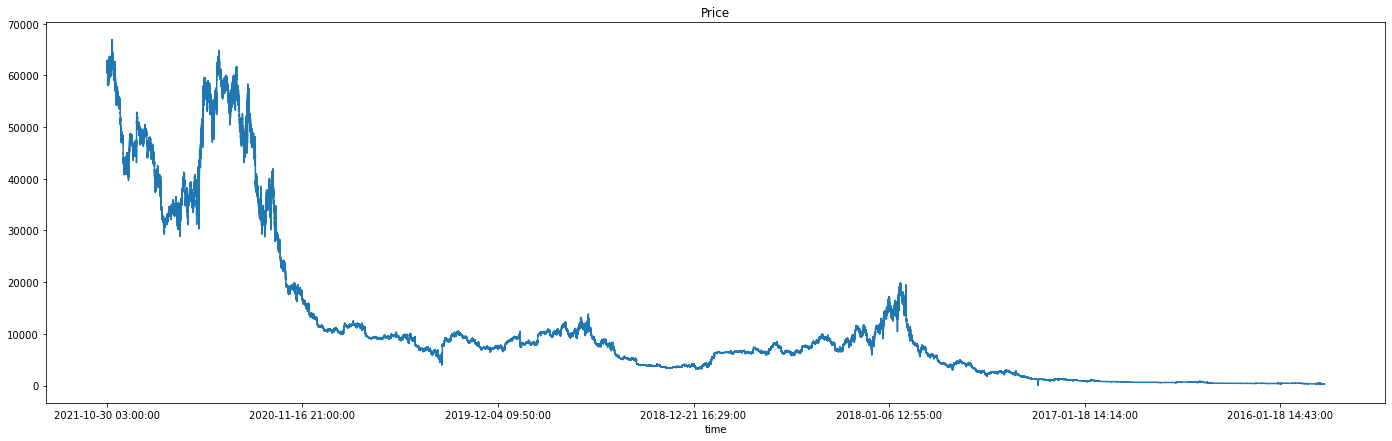

In [6]:
btc.set_index("time").close.plot(figsize=(24,7), title="Price")

# Data Preprocessing

In [7]:
num_shape = 2000

train = btc.iloc[:num_shape, 1:2].values
test = btc.iloc[num_shape:, 1:2].values

# Scaling our features using normalization. 

In [8]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

# Now we take one row and cut it with a window of 60 elements

In [9]:
X_train = []

#Price on next day
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [10]:
# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [12]:
model.fit(X_train, y_train, epochs = 100, batch_size = 128)

Epoch 1/100
16/16 [==============================] - 25s 405ms/step - loss: 0.1442
Epoch 2/100
16/16 [==============================] - 6s 397ms/step - loss: 0.0185
Epoch 3/100
16/16 [==============================] - 6s 401ms/step - loss: 0.0141
Epoch 4/100
16/16 [==============================] - 7s 415ms/step - loss: 0.0119
Epoch 5/100
16/16 [==============================] - 6s 380ms/step - loss: 0.0096
Epoch 6/100
16/16 [==============================] - 6s 398ms/step - loss: 0.0083
Epoch 7/100
16/16 [==============================] - 6s 392ms/step - loss: 0.0085
Epoch 8/100
16/16 [==============================] - 6s 390ms/step - loss: 0.0076
Epoch 9/100
16/16 [==============================] - 7s 417ms/step - loss: 0.0083
Epoch 10/100
16/16 [==============================] - 6s 396ms/step - loss: 0.0077
Epoch 11/100
16/16 [==============================] - 7s 422ms/step - loss: 0.0071
Epoch 12/100
16/16 [==============================] - 6s 404ms/step - loss: 0.0068
Epoch 13/100

16/16 [==============================] - 6s 378ms/step - loss: 0.0034
Epoch 100/100
16/16 [==============================] - 6s 374ms/step - loss: 0.0033


In [16]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [17]:
X_test

array([[[  0.06602156],
        [  0.        ],
        [  0.02915768],
        ...,
        [  0.66578541],
        [  0.66549738],
        [  0.65056948]],

       [[  0.        ],
        [  0.02915768],
        [  0.61705131],
        ...,
        [  0.66549738],
        [  0.65056948],
        [  0.64565963]],

       [[  0.02915768],
        [  0.61705131],
        [  0.62034934],
        ...,
        [  0.65056948],
        [  0.64565963],
        [  0.6394775 ]],

       ...,

       [[-10.94183343],
        [-10.94183343],
        [-10.94186013],
        ...,
        [-10.94258688],
        [-10.94258116],
        [-10.94257925]],

       [[-10.94183343],
        [-10.94186013],
        [-10.94187348],
        ...,
        [-10.94258116],
        [-10.94257925],
        [-10.94261549]],

       [[-10.94186013],
        [-10.94187348],
        [-10.94187348],
        ...,
        [-10.94257925],
        [-10.94261549],
        [-10.94257734]]])

In [ ]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

 3301/97228 [>.............................] - ETA: 1:32:38

In [ ]:
diff = predict - test
print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(btc['time'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(btc['time'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,btc[1800:].shape[0],20))
plt.title('Crypto Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# 10-day prediction

In [ ]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = btc.iloc[:, 1:2][1:].values

for j in range(10):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [ ]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [ ]:
df_date = btc[['time']]

for h in range(10):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(btc['time'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df_date['time'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,btc[1700:].shape[0],200))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()